In [1]:
import os
import time
import pickle
import importlib
import numpy as np
import torch
import mmengine
import matplotlib.pyplot as plt
os.chdir('../')
from model.model import TrajectoryModel

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-a4hnk5g0 because the default path (/home/hello/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
dataset_path = './data/'
dataset_name = 'CODA'
hp_config = 'configs/coda.py'
lr_scaling = False
num_workers = 8
obs_len = 8
pred_len = 12
gpu = 0
data_scaling = [1.9, 0.4]
checkpoint = './checkpoint/'

In [3]:
track_results = mmengine.load('./data/CODA/coda_track_results.pkl')

spec = importlib.util.spec_from_file_location("hp_config", hp_config)
hp_config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(hp_config)

motion_modes_file = dataset_path + dataset_name + '_motion_modes.pkl'
f = open(dataset_path + dataset_name + '_motion_modes.pkl', 'rb+')
motion_modes = pickle.load(f)
f.close()
motion_modes = torch.tensor(motion_modes, dtype=torch.float32).cuda()

model = TrajectoryModel(in_size=2, obs_len=obs_len, pred_len=pred_len, embed_size=hp_config.model_hidden_dim, 
            enc_num_layers=2, int_num_layers_list=[1,1], heads=4, forward_expansion=2)
model.load_state_dict(torch.load(checkpoint + dataset_name + '/best.pth'))
model = model.cuda()
model.eval()

TrajectoryModel(
  (embedding): Linear(in_features=40, out_features=128, bias=True)
  (mode_encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attn): MultihHeadAttention(
          (w_key): Linear(in_features=128, out_features=128, bias=True)
          (w_query): Linear(in_features=128, out_features=128, bias=True)
          (w_value): Linear(in_features=128, out_features=128, bias=True)
          (fc_out): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm1): LayerNorm()
        (norm2): LayerNorm()
        (feed_forward): FeedForwardLayer(
          (w1): Linear(in_features=128, out_features=256, bias=True)
          (w2): Linear(in_features=256, out_features=128, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (nei_embed

In [4]:
pedestrian_label = 1
all_tracks = []
for sequence_results in track_results:
    
    tracks = {}
    frame_len = len(sequence_results['data_list'][pedestrian_label])
    for i, frame_result in enumerate(sequence_results['data_list'][pedestrian_label]):
        track_bboxes = frame_result['track_bboxes']
        track_ids = frame_result['track_ids']
        track_states = frame_result['track_states']
        for j in range(len(track_bboxes)):
            tokens = track_states[j].split('_')
            if tokens[0] == 'birth':
                valid =  True
            elif len(tokens) < 3:
                valid =  False
            elif tokens[0] == 'alive' and int(tokens[1]) == 1:
                valid =  True
            if tracks.get(track_ids[j]) is None:
                tracks[track_ids[j]] = [[1e9, 1e9]] * (i + 6)
            if valid:
                tracks[track_ids[j]].append(track_bboxes[j][:2].tolist())
            else:
                tracks[track_ids[j]].append([1e9, 1e9])
    
    for i in tracks.keys():
        lost_frame = -1
        for j in range(7, len(tracks[i])):
            if tracks[i][j][0] > 1e8 and tracks[i][j-1][0] < 1e8:
                lost_frame = j
            elif lost_frame != -1:
                # 对于丢失的轨迹，进行线性插值
                start = tracks[i][lost_frame-1]
                end = tracks[i][j]
                for l in range(lost_frame, j):
                    tracks[i][l][0] = start[0] + (end[0] - start[0]) / (j - lost_frame) * (l - lost_frame)
                    tracks[i][l][1] = start[1] + (end[1] - start[1]) / (j - lost_frame) * (l - lost_frame)
                lost_frame = -1
        if len(tracks[i]) < frame_len + 6:
            tracks[i].extend([[1e9, 1e9]] * (frame_len + 6 - len(tracks[i])))
            
    all_tracks.append(tracks)

In [5]:
def visual(obs, preds, scores, ids):
    # obs [B T_obs 2]
    # preds [B num_k T_pred 2]
    # scores [B num_k]
    # ids [B]
    plt.clf()
    for i in range(obs.shape[0]):
        ob = obs[i].cpu().numpy()
        pred = preds[i].cpu().numpy()
        score = scores[i].cpu().numpy()
        ob_x = ob[:, 0]
        ob_y = ob[:, 1]
        plt.plot(ob_x, ob_y, marker='o', color='green')
        plt.text(ob_x[-1], ob_y[-1], str(ids[i]),  ha='center')
       
        for j in range(pred.shape[0]):
            pred_x = np.concatenate((ob_x[-1:], pred[j][:, 0]))
            pred_y = np.concatenate((ob_y[-1:], pred[j][:, 1]))
            plt.plot(pred_x, pred_y, ls='-.', lw=0.5, color='red')
            plt.scatter(pred_x[-1], pred_y[-1], marker='*', color='red', s=100)
            plt.text(pred_x[-1], pred_y[-1], str("%.2f" % score[j]),  ha='center')
        
    plt.tight_layout()
    save_path = './fig/' + dataset_name
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(save_path + '/' + str(time.time()) + '.png')
    return

In [6]:
def data_preprocess(tracks):

    track_len, frame_len = tracks.shape[:2]
    data_inputs = []
    for j in range(7, frame_len):
        obs = []
        neis = []
        n_neighbors = []
        neis_mask = []
        refs = []
        rot_mats = []
        ids = []
        now_tracks = tracks[:, j-7:j+1]
        for i in range(track_len):
            if now_tracks[i][-1][0] < 1e8 and now_tracks[i][-2][0] < 1e8:
                # 获取当前轨迹的观测值ob和邻居nei
                ob = now_tracks[i].copy()
                for k in range(6, -1, -1):
                    if ob[k][0] > 1e8:
                        ob[k] = ob[k+1]
                nei = now_tracks[np.arange(track_len) != i]
                dist_mask = nei[:, :, 0] > 1e8
                dist = np.linalg.norm(ob.reshape(1, 8, 2) - nei, axis=-1)
                dist[dist_mask] = 1e9
                dist = np.min(dist, axis=-1)
                nei = nei[dist < hp_config.dist_threshold]

                # 平移变换
                refs.append(ob[-1])
                nei = nei - ob[-1]
                ob = ob - ob[-1]

                # 旋转变换
                angle = np.arctan2(ob[0][1], ob[0][0])
                rot_mat = np.array([[np.cos(angle), -np.sin(angle)], 
                                    [np.sin(angle), np.cos(angle)]], dtype=np.float32)
                ob = np.matmul(ob, rot_mat)
                if nei.shape[0] != 0:
                    nei = np.matmul(nei, rot_mat)

                obs.append(ob)
                neis.append(nei)
                n_neighbors.append(nei.shape[0])
                rot_mats.append(rot_mat)
                ids.append(track_ids[i])

        # 对于邻居数不足的轨迹，进行padding
        max_neighbors = max(n_neighbors)
        if max_neighbors == 0:
            max_neighbors = 1
        neis_pad = []
        for neighbor, n in zip(neis, n_neighbors):
            neis_pad.append(np.pad(neighbor, ((0, max_neighbors-n), (0, 0),  (0, 0)), "constant"))
            mask = np.zeros((max_neighbors, max_neighbors))
            mask[:n, :n] = 1
            neis_mask.append(mask)
    
        obs = torch.tensor(np.stack(obs), dtype=torch.float32).cuda()
        neis = torch.tensor(np.stack(neis_pad), dtype=torch.float32).cuda()
        neis_mask = torch.tensor(np.stack(neis_mask), dtype=torch.float32).cuda()
        refs = torch.tensor(np.stack(refs), dtype=torch.float32).cuda()
        rot_mats = torch.tensor(np.stack(rot_mats), dtype=torch.float32).cuda()
        data_inputs.append((obs, neis, neis_mask, refs, rot_mats, ids))

    return data_inputs

0
199 528


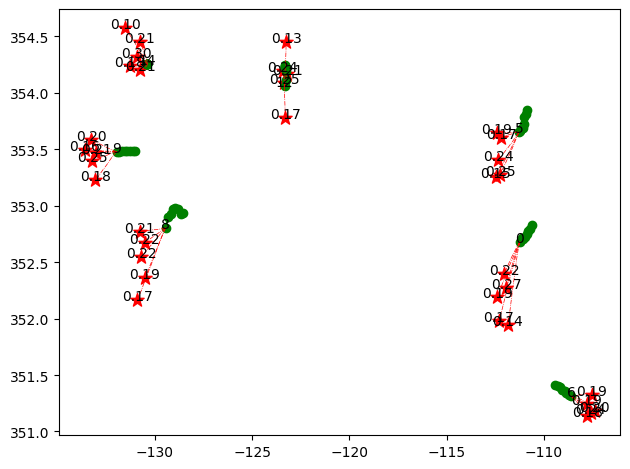

In [ ]:
all_traj_pre_results = []
for i in range(len(all_tracks)):
    track_ids = list(all_tracks[i].keys())
    tracks = np.array([all_tracks[i][k] for k in track_ids], dtype=np.float32)
    print(i)
    data_inputs = data_preprocess(tracks)
    num_traj = 0
    traj_pre_results = []
    with torch.no_grad():
        for j in range(len(data_inputs)):
            obs, neis, neis_mask, refs, rot_mats, ids = data_inputs[j]
            num_traj += obs.shape[0]
            start = time.time()
            preds, scores = model(obs, neis, motion_modes, neis_mask, None, test=True, num_k=3)
            scores = torch.nn.functional.softmax(scores, dim=-1)
            preds = preds.reshape(preds.shape[0], preds.shape[1], 12, 2)
            rot_mats_T = rot_mats.transpose(1, 2)
            obs_ori = torch.matmul(obs, rot_mats_T) + refs.unsqueeze(1)
            preds_ori = torch.matmul(preds, rot_mats_T.unsqueeze(1)) + refs.unsqueeze(1).unsqueeze(2)
            visual(obs_ori, preds_ori, scores, ids)
            traj_pre_results.append({'track_ids': ids, 'obs':obs_ori.cpu().numpy(), 'preds': preds_ori.cpu().numpy(), 'scores': scores.cpu().numpy()})
            if j == 100:
                break
    print(len(data_inputs), num_traj)
    all_traj_pre_results.append({'token': track_results[i]['token'], 'data_list': traj_pre_results})
    break

In [14]:
neis

tensor([[[[ 0.7957, -1.3587],
          [ 0.7298, -1.3163],
          [ 0.6718, -1.2864],
          [ 0.6187, -1.2589],
          [ 0.4851, -1.2853],
          [ 0.4070, -1.2712],
          [ 0.3280, -1.2570],
          [ 0.4364, -0.9971]]],


        [[[-0.6839,  0.7264],
          [-0.7635,  0.6877],
          [-0.8444,  0.6483],
          [-0.9186,  0.6122],
          [-0.9203,  0.5609],
          [-0.9415,  0.5248],
          [-0.9840,  0.4498],
          [-1.0149,  0.3932]]],


        [[[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]]]], device='cuda:0')

In [42]:
obs_ori, preds_ori, scores, ids

199

In [13]:
scores

tensor([[9.9998e-01, 1.4315e-05, 8.6078e-06, 6.0097e-07, 2.3276e-07],
        [9.9998e-01, 1.4317e-05, 8.6086e-06, 6.0103e-07, 2.3277e-07],
        [9.9998e-01, 1.4520e-05, 8.7606e-06, 6.1525e-07, 2.4160e-07]],
       device='cuda:0')